In [69]:
"""
Assumptions:

(1) For now we will assume the user can only take the bus (besides the 'no_bus' option). If we want them to have the option just to walk,
    then we need to modify how we filter the dataframe.

(2) We also are using total time, which includes waiting time.

(3) If obj_option is set to 'no_bus', then walking distance is plotted, not time.
"""

"\nAssumptions:\n\n(1) For now we will assume the user can only take the bus (besides the 'no_bus' option). If we want them to have the option just to walk,\n    then we need to modify how we filter the dataframe.\n\n(2) We also are using total time, which includes waiting time.\n\n(3) If obj_option is set to 'no_bus', then walking distance is plotted, not time.\n"

In [70]:
import json
import pandas as pd
import os
import time
import math
import folium
from folium.plugins import HeatMap
import veroviz as vrv
ORS_API_KEY = os.environ['ORSKEY']
vrv.checkVersion()
print(vrv.checkVersion())

Your current installed version of veroviz is 0.4.6, the latest version available is 0.4.5. To update to the latest version, type `pip install --upgrade veroviz` at a command-line prompt.


In [71]:
# Hyperparameters
experiment = "BNMC_new_time"  # Options: "BNMC", "BNMC_new_time", "test"
obj_option = 'best_walk'  # Options: 'best_time', 'best_walk', 'no_bus'
agg_metric = 'max'  # Options: 'mean', 'max', 'range'

In [72]:
#df = vrv.importDataframe(filename = f'experiments/{experiment}/results.csv')
df = pd.read_csv(f'experiments/{experiment}/results.csv')

In [73]:
# Filter
if obj_option == 'best_time':
    df = df[df["best_time"] == True]
elif obj_option == 'best_walk':
    df = df[df["best_walk"] == True]
else:
    df = df[df["use_bus"] == False]

In [74]:
# Print walking summary statistics
summary = df['total_walk'].describe()
summary['variance'] = df['total_walk'].var() 
summary['range'] = df['total_walk'].max() - df['total_walk'].min()  

print("Summary Statistics for Walking Distance:")
print(summary)

Summary Statistics for Walking Distance:
count       608.000000
mean          0.445079
std           0.156147
min           0.106309
25%           0.325838
50%           0.429007
75%           0.557145
max           0.866369
variance      0.024382
range         0.760060
Name: total_walk, dtype: float64


In [75]:
"""
ERROR: 
    For some reason this code produces output that does not make sense. When calculating the max, 
    the max value of the grouped total_walk column should be the same afterward, but it somehow gets reduced.
UPDATE:
    It now seems to be working after resetting the Python environment.
"""

# Define a custom function for range
def calculate_range(series):
    return series.max() - series.min()

def calculate_max(series):
    return series.max()

def calculate_mean(series):
    return series.mean()

def aggregate_data(df, agg_func):
    if agg_func == 'range':
        agg_operation = calculate_range
    elif agg_func == 'max':
        agg_operation = calculate_max
    else:
        agg_operation = calculate_mean

    grouped = df.groupby(['poi_name', 'start_name']).agg({
        'total_time': agg_operation,  # Aggregation based on the argument
        'total_walk': agg_operation,  # Aggregation based on the argument
        'origin_lat': 'first',
        'origin_lon': 'first',
        'destination_lat': 'first',
        'destination_lon': 'first'
    }).reset_index()


    return grouped.sort_values(by='start_name').reset_index(drop=True)


grouped = aggregate_data(df, agg_metric)

max_value = df['total_walk'].max()
print(f"original df max value = {max_value}")

max_value = grouped['total_walk'].max()
print(f"grouped df max value = {max_value}")

original df max value = 0.8663690016746981
grouped df max value = 0.8663690016746981


In [76]:
def aggregate_data(df, agg_func):
    # Validate the aggregation function input
    if agg_func not in ['range', 'max', 'mean']:
        raise ValueError("Unsupported aggregation function. Please use 'range' or 'max'.")

    # Determine the appropriate aggregation operation
    if agg_func == 'range':
        agg_operation = calculate_range
    elif agg_func == 'max':  # 'max'
        agg_operation = calculate_max
    else:
        agg_operation = calculate_mean

    # Define a custom aggregation dictionary for clarity
    agg_dict = {
        'total_time': agg_operation,  # Custom aggregation for these columns
        'total_walk': agg_operation,
        'origin_lat': 'first',  # Preserving the first value for these columns
        'origin_lon': 'first',
        'destination_lat': 'first',
        'destination_lon': 'first'
    }

    # Apply grouping and aggregation
    grouped = df.groupby(['poi_name', 'start_name'], as_index=False).agg(agg_dict)

    return grouped.sort_values(by='start_name').reset_index(drop=True)

# Example usage
grouped= aggregate_data(df, agg_metric)

# Output the max total_walk values for verification
original_max = df['total_walk'].max()
print(f"Original df max total_walk value = {original_max}")

grouped_max_total_walk = grouped['total_walk'].max()
print(f"Grouped df max total_walk value = {grouped_max_total_walk}")


Original df max total_walk value = 0.8663690016746981
Grouped df max total_walk value = 0.8663690016746981


In [77]:
import pandas as pd

# Assuming df is your DataFrame

# Get unique combinations of 'poi_name' and 'start_name'
group_keys = df[['poi_name', 'start_name']].drop_duplicates()

# Placeholder for storing group-wise maximum values of 'total_walk'
group_max_values = []

for _, row in group_keys.iterrows():
    # Filter the DataFrame for the current group
    group_df = df[(df['poi_name'] == row['poi_name']) & (df['start_name'] == row['start_name'])]
    
    # Calculate the maximum 'total_walk' value for this group and store it
    group_max_values.append(group_df['total_walk'].max())

# Calculate the overall maximum of the group-wise maximums
overall_max_from_groups = max(group_max_values)

print(f"Manually computed overall maximum of 'total_walk' from group-wise maximums: {overall_max_from_groups}")

# Calculate the original maximum for comparison
original_max = df['total_walk'].max()

print(f"Original maximum value of 'total_walk': {original_max}")


Manually computed overall maximum of 'total_walk' from group-wise maximums: 0.8663690016746981
Original maximum value of 'total_walk': 0.8663690016746981


In [78]:
"""
def add_to_node(vrv_df, grouped, index, color='blue'):
    vrv_df = vrv.createNodesFromLocs(
        locs=[[grouped.loc[index, 'origin_lat'], grouped.loc[index, 'origin_lon']]],
        initNodes=vrv_df,
        nodeType="origin",
        nodeName=grouped.loc[index, 'start_name'], # Name of the index
        startNode=1,
        incrementName=False,
        incrementStart=1,
        snapToRoad=False,
        dataProvider=None,
        dataProviderArgs=None,
        popupText=grouped.loc[index, 'start_name'], # Name of the stop location
        leafletIconPrefix='glyphicon',
        leafletIconType='info-sign',
        leafletColor=color,
        leafletIconText=None,
        cesiumIconType='pin',
        cesiumColor=color,
        cesiumIconText=None)
    return vrv_df

vrv_df = vrv.initDataframe('Nodes')
for index in grouped.index:
    vrv_df = add_to_node(vrv_df, grouped, index, color='blue')

myMap = vrv.createLeaflet(nodes=vrv_df)
myMap
"""

'\ndef add_to_node(vrv_df, grouped, index, color=\'blue\'):\n    vrv_df = vrv.createNodesFromLocs(\n        locs=[[grouped.loc[index, \'origin_lat\'], grouped.loc[index, \'origin_lon\']]],\n        initNodes=vrv_df,\n        nodeType="origin",\n        nodeName=grouped.loc[index, \'start_name\'], # Name of the index\n        startNode=1,\n        incrementName=False,\n        incrementStart=1,\n        snapToRoad=False,\n        dataProvider=None,\n        dataProviderArgs=None,\n        popupText=grouped.loc[index, \'start_name\'], # Name of the stop location\n        leafletIconPrefix=\'glyphicon\',\n        leafletIconType=\'info-sign\',\n        leafletColor=color,\n        leafletIconText=None,\n        cesiumIconType=\'pin\',\n        cesiumColor=color,\n        cesiumIconText=None)\n    return vrv_df\n\nvrv_df = vrv.initDataframe(\'Nodes\')\nfor index in grouped.index:\n    vrv_df = add_to_node(vrv_df, grouped, index, color=\'blue\')\n\nmyMap = vrv.createLeaflet(nodes=vrv_df)\nm

In [79]:
"""
This was a first attempt, but it is not what we want. 
The circles become red when the circles overlap. This is more about the proximity of the origins and less
so about the values of the times/distances.
"""

# Calculate the center of the map based on the mean of the latitude and longitude
map_center_lat = grouped['origin_lat'].mean()
map_center_lon = grouped['origin_lon'].mean()

# Create a map centered around the calculated mean latitude and longitude
m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=14)

# Generate a list of tuples containing latitude, longitude, and 'total_time' (or 'total_walk') for the heatmap
if obj_option == 'best_time':
    obj_col = 'total_time'
else:
    obj_col = 'total_walk'
heat_data = [(row['origin_lat'], row['origin_lon'], row[obj_col]) for index, row in grouped.iterrows()]

# Create and add a HeatMap layer
# 'min_opacity' can be adjusted for visual clarity, 'radius' controls the spread of the heat from each point
# 'blur' controls the amount of smoothing applied to the heat map
HeatMap(heat_data, min_opacity=0.5, 
        radius=15, blur=1, max_zoom=1).add_to(m)

# Save and display the map
#m.save('heatmap.html')  # Save to HTML file
m

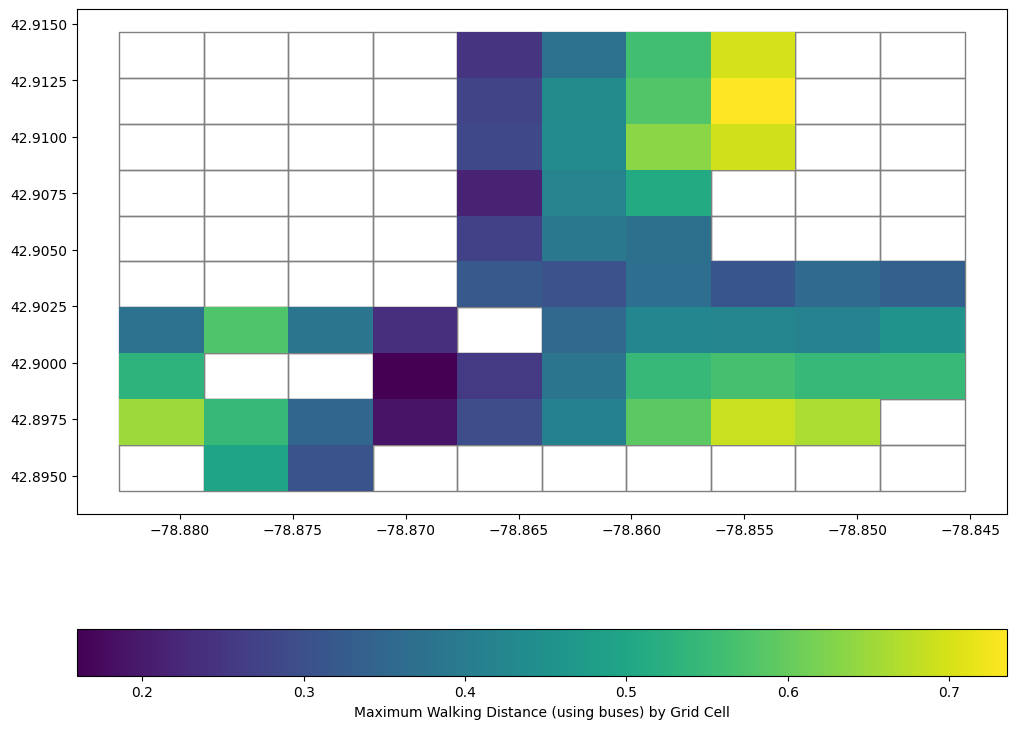

In [80]:
"""
Here we are getting better.
The logic is now correct, but we would prefer it to be on a geographical map, not a blank 2D grid.
"""

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, box
import shapely

gdf = gpd.GeoDataFrame(grouped, geometry=gpd.points_from_xy(grouped.origin_lon, grouped.origin_lat))

# Define the bounds of the grid
num_div = 10  # 10 seems like a good number for this value
x_min, y_min, x_max, y_max = gdf.total_bounds
width = (x_max - x_min) / num_div  # Number of cells horizontally
height = (y_max - y_min) / num_div  # Number of cells vertically

# Create the cells in the grid
rows = int(np.ceil((y_max - y_min) / height))
cols = int(np.ceil((x_max - x_min) / width))
grid_cells = []

for i in range(cols):
    for j in range(rows):
        minx = x_min + i * width
        maxx = x_min + (i + 1) * width
        miny = y_min + j * height
        maxy = y_min + (j + 1) * height
        grid_cells.append(box(minx, miny, maxx, maxy))

grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

# Ensure the grid has an explicit index column before the spatial join
grid['grid_index'] = range(len(grid))

# Spatial join between the grid and the GeoDataFrame
merged = gpd.sjoin(grid, gdf, how='left', predicate='intersects')


# Ensure 'total_time' is a float to avoid data type issues during aggregation
merged[obj_col] = merged[obj_col].astype(float)

# Aggregate 'total_time' in each grid cell using 'grid_index' to identify cells
aggregated = merged.dissolve(by="grid_index", aggfunc="mean")

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
grid.plot(ax=ax, facecolor='none', edgecolor='grey')

if obj_option == 'best_time':
    lg_txt = 'Time'
else:
    lg_txt = 'Walking Distance'

if obj_option == 'no_bus':
    lg_txt += ' (only walking; no buses)'
else:
    lg_txt += ' (using buses)'


if agg_metric == 'mean':
    lg_metric = "Average"
if agg_metric == 'max':
    lg_metric = "Maximum"
else:
    lg_metric = "Range"
aggregated.plot(column=obj_col, ax=ax, legend=True,
                legend_kwds={'label': f"{lg_metric} {lg_txt} by Grid Cell",
                             'orientation': "horizontal"})
plt.show()

# After aggregating, reset the index so 'grid_index' becomes a column
aggregated.reset_index(inplace=True)

# Convert the aggregated GeoDataFrame to GeoJSON
aggregated_json = aggregated.to_json()

In [81]:
max_value = df['total_walk'].max()
print(f"original df max value = {max_value}")

max_value = grouped['total_walk'].max()
print(f"grouped df max value = {max_value}")

max_value = gdf['total_walk'].max()
print(f"gdf df max value = {max_value}")

max_value = merged['total_walk'].max()
print(f"merged df max value = {max_value}")

max_value = aggregated['total_walk'].max()
print(f"aggregated df max value = {max_value}")

original df max value = 0.8663690016746981
grouped df max value = 0.8663690016746981
gdf df max value = 0.8663690016746981
merged df max value = 0.8663690016746981
aggregated df max value = 0.73591674115068


In [82]:
"""
Finally, this is what we have been attempting to create!
This shows the grid of averaged/max/range time/distance values overlayed on a geographical map.
"""

import folium

# Create a folium map centered around the mean of the data points
map_center_lat = gdf.geometry.y.mean()
map_center_lon = gdf.geometry.x.mean()
m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=14)

# Add choropleth layer without drawing the grid lines
folium.Choropleth(
    geo_data=aggregated_json,
    name='choropleth',
    data=aggregated,
    columns=['grid_index', obj_col],
    key_on='feature.properties.grid_index',
    fill_color='YlOrRd',  # Color scheme
    fill_opacity=0.7,
    line_opacity=0,  # Setting line opacity to 0 to hide grid lines
    legend_name=f'{lg_metric} {lg_txt}',
    nan_fill_color='none',  # Set empty cells to be transparent
).add_to(m)

# Add a layer control panel to the map
folium.LayerControl().add_to(m)

# Display the map

if obj_option == 'best_time':
    output_name = 'time'
elif obj_option == 'best_walk':
    output_name = 'distance'
else:
    output_name = 'no-buses'
m.save(f'heatmap_{experiment}_{output_name}_{agg_metric}.html')  # Save to HTML file
m
